<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import torch
from torch.utils.data.dataset import random_split
from torchaudio import datasets

from dcunet.dcunet import DCUnet10
from utils.data import get_data, preprocess, WrappedDataLoader
from utils.train import train, wsdr_fn

import matplotlib.pyplot as plt
import IPython.display as ipd

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torchaudio\backend\utils.py:64: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  'The interface of "soundfile" backend is planned to change in 0.8.0 to '


In [2]:
print(torch.cuda.is_available())
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

dataset = datasets.VCTK_092(root="data", download=False)

ds_size = len(dataset)
train_i = int(0.1 * ds_size)
train_i += train_i % 2
val_i = int(0.11 * ds_size) - train_i
val_i += val_i % 2
test_i = ds_size - train_i - val_i

train_ds, val_ds, test_ds = random_split(dataset, lengths=[train_i, val_i, test_i],
                                         generator=torch.Generator().manual_seed(42))

batch_size = 1
DEVICE = dev
SAMPLE_RATE = 48000
N_FFT = SAMPLE_RATE * 64 // 1000 + 4
HOP_LENGTH = SAMPLE_RATE * 16 // 1000 + 4

train_dl, val_dl, test_dl = get_data(train_ds, val_ds, test_ds, batch_size)
train_dl = WrappedDataLoader(train_dl, preprocess, HOP_LENGTH, DEVICE)
val_dl = WrappedDataLoader(val_dl, preprocess, HOP_LENGTH, DEVICE)
test_dl = WrappedDataLoader(test_dl, preprocess, HOP_LENGTH, DEVICE)

dcunet10 = DCUnet10(N_FFT, HOP_LENGTH).to(DEVICE)

loss_fn = wsdr_fn
optimizer = torch.optim.Adam(dcunet10.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

True


In [3]:
test_ep_loss = 0.
counter = 0.
for i, (noisy_x, clean_x) in enumerate(val_dl):
#     print(i, len(val_dl))
    # get the output from the model
    noisy_x, clean_x = noisy_x.to(dev), clean_x.to(dev)
#     pred_x = net(noisy_x)

    # calculate loss
    loss = loss_fn(noisy_x, noisy_x, clean_x)
    test_ep_loss += loss.item()

    counter += 1
test_ep_loss /= counter
print(test_ep_loss)

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
  normalized, onesided, return_complex)
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\functional.py:587: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:602.)
  normalized, onesided, length, return_complex)


-0.8117369356220716


In [7]:
train_losses, test_losses = train(dcunet10, train_dl, val_dl, loss_fn, optimizer, scheduler, 100, dev)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Loss before training:-0.926840
99 / 4388 -0.9241113734967781
199 / 4388 -0.9236647816159618
299 / 4388 -0.9236531341354982
399 / 4388 -0.923448197674333
499 / 4388 -0.9235108061161691
599 / 4388 -0.9235667396268383
699 / 4388 -0.9239623639546068
799 / 4388 -0.9242018602965621
899 / 4388 -0.9243076653846511
999 / 4388 -0.9242778958620371
1099 / 4388 -0.9243113596510952
1199 / 4388 -0.9243535906001863
1299 / 4388 -0.9244175572593548
1399 / 4388 -0.9243239195028146
1499 / 4388 -0.9243321663304279
1599 / 4388 -0.9242694545642073
1699 / 4388 -0.9244134771325716
1799 / 4388 -0.9243266410864744
1899 / 4388 -0.9243674045992626
1999 / 4388 -0.9244091162805619
2099 / 4388 -0.9243032721862048
2199 / 4388 -0.9243381071925543
2299 / 4388 -0.9243621362090474
2399 / 4388 -0.924356950079714
2499 / 4388 -0.9242460578143382
2599 / 4388 -0.9242335149718046
2699 / 4388 -0.92424186420423
2799 / 4388 -0.9242302572015951
2899 / 4388 -0.9242031784582319
2999 / 4388 -0.9241722736926268
3099 / 4388 -0.924182573

  1%|▊                                                                            | 1/100 [20:50<34:23:23, 1250.54s/it]

Epoch: 1/100... Loss: -0.924210... Test Loss: -0.925479
99 / 4388 -0.9252105505779536
199 / 4388 -0.9245687303830631
299 / 4388 -0.9245950591604047
399 / 4388 -0.9245685123859492
499 / 4388 -0.9244530393269831
599 / 4388 -0.9245416582725283
699 / 4388 -0.924570627222757
799 / 4388 -0.9244692545659252
899 / 4388 -0.924438520785301
999 / 4388 -0.9245122516000116
1099 / 4388 -0.9241704666907403
1199 / 4388 -0.9240286715633179
1299 / 4388 -0.9239265404819432
1399 / 4388 -0.923961855625578
1499 / 4388 -0.9239439459305115
1599 / 4388 -0.9236198668184692
1699 / 4388 -0.9235924737042297
1799 / 4388 -0.9236437379816892
1899 / 4388 -0.9236415016331002
1999 / 4388 -0.9236065111141195
2099 / 4388 -0.9235361744359086
2199 / 4388 -0.9235346904663998
2299 / 4388 -0.9235535171976708
2399 / 4388 -0.9236421209914131
2499 / 4388 -0.9237715511524281
2599 / 4388 -0.9237649129784625
2699 / 4388 -0.9237658957853808
2799 / 4388 -0.9237437264627114
2899 / 4388 -0.9237555067224229
2999 / 4388 -0.923805809827914

  2%|█▌                                                                           | 2/100 [43:20<35:38:06, 1309.04s/it]

Epoch: 2/100... Loss: -0.923929... Test Loss: -0.924700
99 / 4388 -0.923138708177239


  2%|█▌                                                                           | 2/100 [43:45<35:44:00, 1312.66s/it]


KeyboardInterrupt: 

In [8]:
xi = iter(val_dl)

In [44]:
x = next(xi)
x_noisy = x[0][0]
x_true = x[1][0]
with torch.no_grad():
    x_pred = dcunet10(x_noisy.unsqueeze(0))
x_pred = x_pred / (x_pred.max() - x_pred.min()) * (x_true.max() - x_true.min())

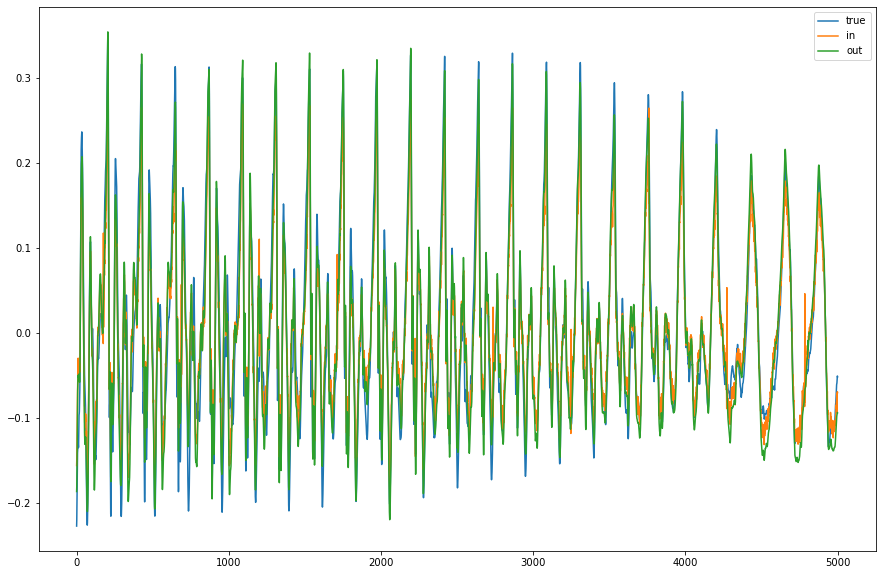

In [45]:
sl = slice(50000, 55000)
plt.figure(figsize=(15,10))
plt.plot(x_true.squeeze().cpu()[sl])

plt.plot(x_noisy.squeeze().cpu()[sl])
plt.plot(x_pred.squeeze().cpu()[sl])

plt.legend(["true", "in", "out"])

In [46]:
display(ipd.Audio(x_noisy.squeeze().cpu(), rate=SAMPLE_RATE));

In [47]:
display(ipd.Audio(x_true.squeeze().cpu(), rate=SAMPLE_RATE));

In [48]:
display(ipd.Audio(x_pred.squeeze().cpu(), rate=SAMPLE_RATE));

In [12]:
from utils.train import wsdr_fn

In [49]:
wsdr_fn(x_noisy.unsqueeze(0), x_noisy.unsqueeze(0), x_true.unsqueeze(0))

tensor(-0.8580, device='cuda:0')

In [50]:
wsdr_fn(x_noisy.unsqueeze(0), x_pred.unsqueeze(0), x_true.unsqueeze(0))

tensor(-0.9275, device='cuda:0')

In [42]:
torch.save(dcunet10.state_dict(), "new_dcu.pth")

In [15]:
net = DCUnet10(N_FFT, HOP_LENGTH).to(DEVICE)
net.load_state_dict(torch.load("new_dcu.pth"))

<All keys matched successfully>

In [16]:
with torch.no_grad():
    test_ep_loss = 0.
    counter = 0.
    for i, (noisy_x, clean_x) in enumerate(val_dl):
    #     print(i, len(val_dl))
        # get the output from the model
        noisy_x, clean_x = noisy_x.to(dev), clean_x.to(dev)
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        test_ep_loss += loss.item()

        counter += 1
    test_ep_loss /= counter
    print(test_ep_loss)

-0.925763741203639


In [6]:
dcunet10 = net

In [51]:
import gc
gc.collect()
torch.cuda.empty_cache()